## Init

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn

from glob import iglob


In [2]:
from utils import (
    process_label,
    process_feature
)

### Dataset

In [3]:
from torch.utils.data import (
    Dataset,
    DataLoader
)

In [4]:
dfs = []
num = 0
score = 0

for path in iglob('./dataset/train/*.csv'):
    path = path.replace('\\', '/')
    df = pd.read_csv(path, index_col=0)

    process_label(df, path)
    process_feature(df)

    n = round(df.shape[0] / 120)
    print(path.split('/')[-1], n, '{:.1%}'.format(df['label'].mean()))

    num += n
    score += df['label'].mean() * n

    df = df[
        ['ln_pts', 'z_iqr', 'z_std', 'z_c', 'range', 'l_r', 's_r', 'dist', 'label']
    ].astype('float32').values
    for i in range(n):
        dfs.append(df)

print('total:',num, '{:.1%}'.format(score/num))

ATR_GN_P2-240527-30019-2025-08-31-00-1384880-1388055.csv 24 97.6%
ATR_GN_P2-240527-30019-2025-09-02-00-3097855-3098844.csv 8 98.0%
ATR_GN_P2-240527-30019-2025-09-02-09-3427349-3428726.csv 7 30.3%
ATR_GN_P2-240527-30019-2025-09-16-19-3898000-3901019.csv 12 0.0%
ATR_GN_P2-240601-00069-2025-08-27-15-181634-185130.csv 28 61.5%
ATR_GN_P2-240601-00069-2025-08-29-04-713100-716599.csv 29 98.6%
ATR_GN_P2-240601-00069-2025-09-11-01-1512887-1514137.csv 5 0.0%
ATR_GN_P4-241029-00016-2025-09-01-07-2584784-2591384.csv 49 97.7%
ATR_GN_P4-250120-00138-2025-09-04-15-372127-373946.csv 14 95.0%
ATR_GN_P4-250120-00138-2025-09-07-15-2969150-2970732.csv 13 98.3%
ATR_GN_P4-250120-00138-2025-09-07-20-3155534-3159779.csv 20 3.2%
ATR_GN_P4-250120-00172-2025-09-01-03-7698018-7703053.csv 18 100.0%
P1-TP5-0528test-170695-173549.csv 17 99.8%
P1-TP5-0528test-199959-202507.csv 12 95.8%
P1-TP5-0528test-203583-205322.csv 13 99.4%
total: 269 79.2%


In [5]:
class TrainDataset(Dataset):

    def __init__(self, dfs):
        self.dfs = dfs

    def __len__(self):
        return len(self.dfs)

    def __getitem__(self, idx):
        arr = self.dfs[idx]
        jdx = np.random.choice(arr.shape[0]-79, 1)[0]
        batch = arr[jdx:jdx+80, :-1]
        label = arr[jdx:jdx+80, -1]
        return batch, label


In [6]:
np.random.seed(2025)
torch.manual_seed(2025)

train_ds = TrainDataset(dfs)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0, drop_last=True)

In [7]:
dfs = []

for path in iglob('./dataset/test/*.csv'):
    path = path.replace('\\', '/')
    df = pd.read_csv(path, index_col=0)

    process_label(df, path)
    process_feature(df)

    n = df.shape[0] // 80
    print(path.split('/')[-1], n, '{:.1%}'.format(df['label'].mean()))

    df = df[
        ['ln_pts', 'z_iqr', 'z_std', 'z_c', 'range', 'l_r', 's_r', 'dist', 'label']
    ].astype('float32').values
    for i in range(n):
        dfs.append(df[i*80:(i+1)*80])

len(dfs)

ATR_GN_P2-240527-30019-2025-09-02-01-3123914-3124287.csv 4 28.0%
ATR_GN_P2-240527-30019-2025-09-03-11-4351701-4352882.csv 4 31.6%
ATR_GN_P2-240527-30019-2025-09-18-05-5132024-5133107.csv 3 77.1%
P1-TP5-0528test-185780-186966.csv 11 100.0%


22

In [8]:
class TestDataset(Dataset):

    def __init__(self, dfs):
        self.dfs = dfs

    def __len__(self):
        return len(self.dfs)

    def __getitem__(self, idx):
        arr = self.dfs[idx]
        batch = arr[:, :-1]
        label = arr[:, -1]
        return batch, label

In [9]:
test_ds = TestDataset(dfs)
test_dl = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=0, drop_last=False)

## Model

In [10]:
from torchinfo import summary

from layers import (
    EMA,
    Transpose
)

In [11]:
hs = 64

model = nn.Sequential(
    nn.Linear(8, hs, bias=False),
    Transpose(),
    EMA(hs, length=80),
    Transpose(),
    nn.ReLU6(),
    # nn.Linear(hs, hs//2, bias=False),
    # nn.ReLU6(),
    nn.Linear(hs, 1, bias=False)
)

summary(model, (2, 80, 8), col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [2, 80, 8]                [2, 80, 1]                --
├─Linear: 1-1                            [2, 80, 8]                [2, 80, 64]               512
├─Transpose: 1-2                         [2, 80, 64]               [2, 64, 80]               --
├─EMA: 1-3                               [2, 64, 80]               [2, 64, 80]               128
├─Transpose: 1-4                         [2, 64, 80]               [2, 80, 64]               --
├─ReLU6: 1-5                             [2, 80, 64]               [2, 80, 64]               --
├─Linear: 1-6                            [2, 80, 64]               [2, 80, 1]                64
Total params: 704
Trainable params: 704
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.01
Forward/backward pass size (MB): 0.17
Params size (MB): 0.00
Estimated Total Size (MB): 0.17

### Metric

In [12]:
from torchmetrics import MetricCollection
from torchmetrics.classification import (
    BinaryAccuracy,
    BinaryAUROC
)

In [13]:
# criterion
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=.1**.5)

metric = MetricCollection({'acc':BinaryAccuracy(), 'auc':BinaryAUROC()})

## Train

In [14]:
epochs = 29
step = 0

model.train()

for epoch in range(epochs):

    for batch, label in train_dl:
        logit = model(batch).squeeze(-1)
        loss = loss_fn(logit, label)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        proba = torch.sigmoid(logit)
        metric.update(proba, label)
        step += 1
    scheduler.step()

    # if (epoch % 2 == 1) or (epoch==epochs-1):
    res = metric.compute()
    print(f'epoch {epoch+1:>2d} - acc: {res["acc"]:.4f} - auc: {res["auc"]:.4f}')
    metric.reset()
    torch.save(model.state_dict(), f'./ckpt/epoch{epoch+1:02d}-{res["auc"]:.4f}.pth')


epoch  1 - acc: 0.7121 - auc: 0.5919
epoch  2 - acc: 0.7988 - auc: 0.6696
epoch  3 - acc: 0.8042 - auc: 0.8000
epoch  4 - acc: 0.8044 - auc: 0.8780
epoch  5 - acc: 0.7944 - auc: 0.8382
epoch  6 - acc: 0.7984 - auc: 0.8523
epoch  7 - acc: 0.8136 - auc: 0.8775
epoch  8 - acc: 0.7942 - auc: 0.8689
epoch  9 - acc: 0.8057 - auc: 0.8901
epoch 10 - acc: 0.8121 - auc: 0.9170
epoch 11 - acc: 0.7891 - auc: 0.9134
epoch 12 - acc: 0.7920 - auc: 0.9063
epoch 13 - acc: 0.8024 - auc: 0.9002
epoch 14 - acc: 0.7907 - auc: 0.8950
epoch 15 - acc: 0.7951 - auc: 0.9218
epoch 16 - acc: 0.7924 - auc: 0.9402
epoch 17 - acc: 0.8007 - auc: 0.9005
epoch 18 - acc: 0.7930 - auc: 0.9361
epoch 19 - acc: 0.7902 - auc: 0.9152
epoch 20 - acc: 0.7929 - auc: 0.8929
epoch 21 - acc: 0.7774 - auc: 0.9119
epoch 22 - acc: 0.7837 - auc: 0.9173
epoch 23 - acc: 0.7877 - auc: 0.9084
epoch 24 - acc: 0.7950 - auc: 0.9130
epoch 25 - acc: 0.7986 - auc: 0.8710
epoch 26 - acc: 0.7885 - auc: 0.8973
epoch 27 - acc: 0.7904 - auc: 0.9171
e

In [19]:
model.eval()
metric.reset()

for path in iglob('ckpt/*.pth'):
    ckpt = torch.load(path)
    model.load_state_dict(ckpt)
    s = path.split('\\')[-1]

    for batch, label in test_dl:
        with torch.no_grad():
            logit = model(batch).squeeze(-1)
            proba = torch.sigmoid(logit)

        metric.update(proba, label)

    res = metric.compute()
    print(f'{s}  - acc: {res["acc"]:.4f} - auc: {res["auc"]:.4f}')
    metric.reset()

## Test

In [17]:
from sklearn.metrics import confusion_matrix

In [15]:
model.eval()
metric.reset()

path = 'ckpt/raw/epoch13-0.9202.pth'
ckpt = torch.load(path)
s = path.split('//')[-1]
model.load_state_dict(ckpt)

probas = []
labels = []
for batch, label in test_dl:
    with torch.no_grad():
        logit = model(batch).squeeze(-1)
        proba = torch.sigmoid(logit)

    labels.append(label.flatten().numpy())
    probas.append(proba.flatten().numpy())
    metric.update(proba, label)

res = metric.compute()
print(f'{s}  - acc: {res["acc"]:.4f} - auc: {res["auc"]:.4f}')
metric.reset()

probas = np.concat(probas)
y_true = np.concat(labels)

ckpt/raw/epoch13-0.9202.pth  - acc: 0.7233 - auc: 0.9769


In [29]:
y_pred = probas>0.76
confusion_matrix(y_true, y_pred)

array([[ 387,  100],
       [   9, 1264]])

In [30]:
confusion_matrix(y_true, y_pred, normalize='true')

array([[0.79466119, 0.20533881],
       [0.00706991, 0.99293009]])

## Result

In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [32]:
arr = np.asarray([1, 1, 1, 0, 0, 0, 1, 1])

def pre_broken_barh(arr):
    diff = np.where(np.diff(arr)!=0)[0]
    colors = []
    xranges = []

    for i, j in enumerate(np.r_[-1, diff]):
        colors.append(f'C{arr[j+1]}')
        if i == 0:
            xranges.append((0, float(diff[0])+0.5))
            continue
        elif i < len(diff):
            i = float(diff[i])
        else:
            i = float(len(arr)-1)

        j = float(j)
        xranges.append((j+.5, i-j))
    return xranges, colors


In [ ]:
# df = pd.read_csv('C:/Users/pontosense/Downloads/Target/test2/ATR_GN_P2-240527-30019-2025-09-02-01-3123914-3124977_res.csv').loc[:320-1]
# df = pd.concat(
#     [df,
#     pd.read_csv('C:/Users/pontosense/Downloads/Target/test2/ATR_GN_P2-240527-30019-09-03-11-4351701-4353067_res.csv').loc[:320-1]],
#     ignore_index=True
# )
# df = pd.concat(
#     [df,
#     pd.read_csv('C:/Users/pontosense/Downloads/Target/test2/P1-TP5-0528test-185780-186966_res.csv').loc[:880-1]],
#     ignore_index=True
# )

# xranges, colors = pre_broken_barh(df['pred'].astype(int))
# ax.broken_barh(xranges,  (.2, .6), facecolors=colors)


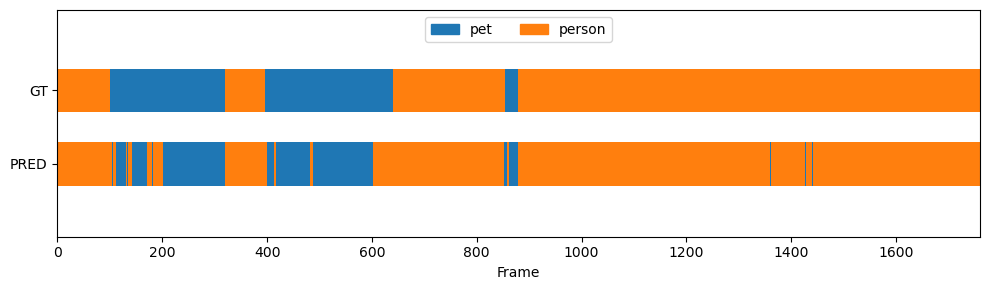

In [35]:
fig, ax = plt.subplots(figsize=(10, 3))

xranges, colors = pre_broken_barh((y_pred).astype(int))
ax.broken_barh(xranges,  (0.2, .6), facecolors=colors)
xranges, colors = pre_broken_barh(y_true.astype(int))
ax.broken_barh(xranges,  (1.2, .6), facecolors=colors)

# 设置坐标范围与样式
ax.set_xlim(0, len(y_true))
ax.set_ylim(-0.5, 2.6)
ax.set_yticks([0.5, 1.5], ['PRED', 'GT'])
ax.set_xlabel("Frame")

pet_patch = mpatches.Patch(color='C0', label='pet')
person_patch = mpatches.Patch(color='C1', label='person')
ax.legend(handles=[pet_patch, person_patch], loc='upper center', ncols=2)

plt.tight_layout()
plt.show()